In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()


(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Aman\AppData\Local\Temp\ipykernel_9420\2720170860.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/5:   0%|          | 0/1201 [00:00<?, ?it/s]C:\Users\Aman\AppData\Local\Temp\ipykernel_9420\2720170860.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-r

Epoch 1/5, Train Loss: 334.3420, Train Accuracy: 88.68%, Validation Accuracy: 89.89%


Epoch 2/5: 100%|██████████| 1201/1201 [06:00<00:00,  3.33it/s]


Epoch 2/5, Train Loss: 154.6419, Train Accuracy: 95.46%, Validation Accuracy: 87.67%


Epoch 3/5: 100%|██████████| 1201/1201 [05:24<00:00,  3.70it/s]


Epoch 3/5, Train Loss: 60.5942, Train Accuracy: 98.47%, Validation Accuracy: 87.98%


Epoch 4/5: 100%|██████████| 1201/1201 [04:35<00:00,  4.36it/s]


Epoch 4/5, Train Loss: 43.5185, Train Accuracy: 98.83%, Validation Accuracy: 88.75%


Epoch 5/5: 100%|██████████| 1201/1201 [03:49<00:00,  5.24it/s]


Epoch 5/5, Train Loss: 33.3660, Train Accuracy: 98.97%, Validation Accuracy: 87.98%


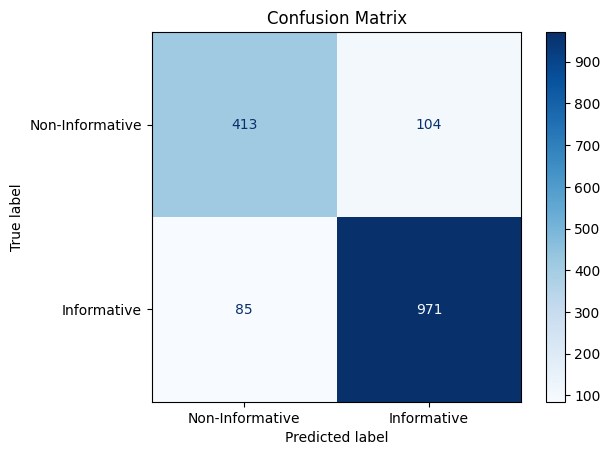

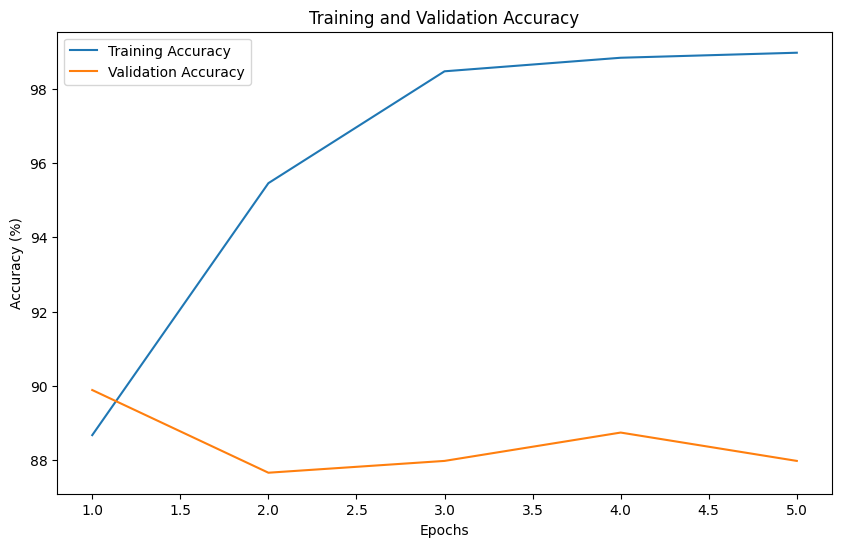

Model saved to clip_multimodal_classifier.pth


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tweet_text']
        image_path = self.image_dir + self.data.iloc[idx]['image']
        label = 1 if self.data.iloc[idx]['label'] == 'informative' else 0  # Convert label to 1 or 0

        # Load image and preprocess
        image = Image.open(image_path).convert("RGB")

        # Process text and image
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        return inputs, torch.tensor(label)

# Define the multimodal classifier
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model):
        super(MultimodalClassifier, self).__init__()
        self.clip_model = clip_model

        # Custom classification layer
        self.classifier = nn.Sequential(
            nn.Linear(clip_model.config.projection_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  # Output 2 classes
        )

    def forward(self, inputs):
        # Extract text and image embeddings separately
        text_embeddings = self.clip_model.get_text_features(inputs['input_ids'].squeeze(1))
        image_embeddings = self.clip_model.get_image_features(inputs['pixel_values'])

        # Concatenate text and image embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=-1)

        # Pass through the custom classifier
        output = self.classifier(combined_embeddings)
        return output

# Load the CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Load the dataset
train_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
val_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')

# Filter datasets to include only samples where 'label_text_image' is "Positive"
train_df_positive = train_df[train_df['label_text_image'] == 'Positive']
val_df_positive = val_df[val_df['label_text_image'] == 'Positive']

# Specify image directory
image_dir = ""  # Replace with the correct path to your image directory

# Create datasets and dataloaders with filtered data
train_dataset_positive = MultimodalDataset(train_df_positive, image_dir, processor)
val_dataset_positive = MultimodalDataset(val_df_positive, image_dir, processor)

train_loader_positive = DataLoader(train_dataset_positive, batch_size=8, shuffle=True)
val_loader_positive = DataLoader(val_dataset_positive, batch_size=8, shuffle=False)

# Initialize the model
model = MultimodalClassifier(clip_model)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=5, save_path="clip_multimodal_classifier.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scaler = torch.cuda.amp.GradScaler()

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = correct_preds / total_preds * 100
        train_accuracies.append(train_accuracy)

        model.eval()
        val_correct_preds = 0
        val_total_preds = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
                labels = labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_accuracy = val_correct_preds / val_total_preds * 100
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {running_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Informative", "Informative"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# Train the model using filtered data
train_model(
    model=model,
    train_loader=train_loader_positive,
    val_loader=val_loader_positive,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=5
)


C:\Users\Aman\AppData\Local\Temp\ipykernel_9420\3584826139.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("clip_multimodal_classifier

Test Loss: 81.4095, Test Accuracy: 88.59%


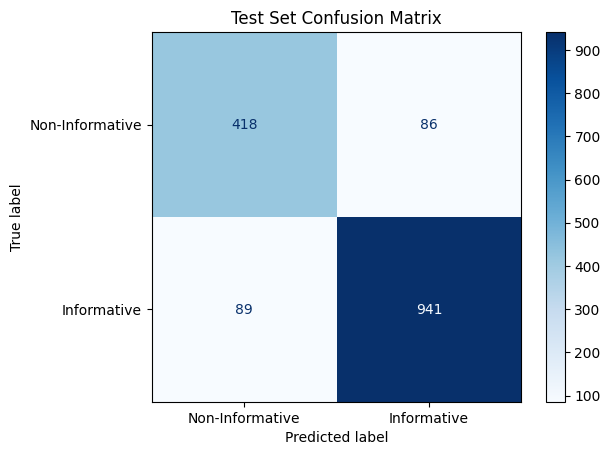

Final Test Accuracy on Positive Samples: 88.59%


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tweet_text']
        image_path = self.image_dir + self.data.iloc[idx]['image']
        label = 1 if self.data.iloc[idx]['label'] == 'informative' else 0  # Convert label to 1 or 0

        # Load image and preprocess
        image = Image.open(image_path).convert("RGB")

        # Process text and image
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        return inputs, torch.tensor(label)

# Define the multimodal classifier
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model):
        super(MultimodalClassifier, self).__init__()
        self.clip_model = clip_model

        # Custom classification layer
        self.classifier = nn.Sequential(
            nn.Linear(clip_model.config.projection_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, inputs):
        # Extract text and image embeddings separately
        text_embeddings = self.clip_model.get_text_features(inputs['input_ids'].squeeze(1))
        image_embeddings = self.clip_model.get_image_features(inputs['pixel_values'])

        # Concatenate text and image embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=-1)

        # Pass through the custom classifier
        output = self.classifier(combined_embeddings)
        return output

# Load the CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Define the testing function
def test_model(model, test_loader, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_correct_preds = 0
    test_total_preds = 0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_correct_preds += (predicted == labels).sum().item()
            test_total_preds += labels.size(0)

            # Store for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_accuracy = test_correct_preds / test_total_preds * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Informative", "Informative"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Test Set Confusion Matrix")
    plt.show()

    return test_accuracy

# Load the test dataset
test_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t')

# Filter the test dataset to include only samples where 'label_text_image' is "Positive"
test_df_positive = test_df[test_df['label_text_image'] == 'Positive']

# Specify image directory
image_dir = ""  # Replace with the correct path to your image directory

# Create test dataset and dataloader with filtered data
test_dataset_positive = MultimodalDataset(test_df_positive, image_dir, processor)
test_loader_positive = DataLoader(test_dataset_positive, batch_size=8, shuffle=False)

# Load the trained model
model = MultimodalClassifier(clip_model)
model.load_state_dict(torch.load("clip_multimodal_classifier.pth"))

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Test the model on filtered positive samples
test_accuracy = test_model(model, test_loader_positive, loss_fn)
print(f"Final Test Accuracy on Positive Samples: {test_accuracy:.2f}%")
